In [1]:
from global_imports import *

In [2]:
from model import *
from model_proposed import *

In [3]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
model_cascaded = CascadedModel(n_channels=4, n_classes=4).to(device).float()
model_cascaded.load_state_dict(torch.load('best_model_cascaded_new.pth', map_location=device))

<All keys matched successfully>

In [5]:
model_baseline = UNet(n_channels=4, n_classes=4).to(device).float()
model_baseline.load_state_dict(torch.load('best_model_baseline.pth', map_location=device))

<All keys matched successfully>

In [37]:
def create_visual_result(images, preds1, preds2, masks, slice_index):
    fig = plt.figure (figsize = (12, 40))
    
    for j in range(len(modality_types)):
        # show all type of images
        plt.subplot (16, 4, j + 1)
        plt.axis ('off')
        plt.title (modality_types[j])
        plt.imshow (images[slice_index][j].cpu(), cmap = 'bone')

    # show True Mask
    plt.subplot (16, 4, 5)
    plt.title ('True Mask')
    plt.axis ('off')
    plt.imshow (masks[slice_index].cpu(), cmap = 'bone')

    # show Predicted Mask
    plt.subplot (16, 4, 6)
    plt.title ('Baseline Prediction')
    plt.axis ('off')
    plt.imshow (preds1[slice_index].cpu(), cmap = 'bone')
    
    plt.subplot (16, 4, 7)
    plt.title ('Cascaded Prediction')
    plt.axis ('off')
    plt.imshow (preds2[slice_index].cpu(), cmap = 'bone')

    return fig

In [38]:
imgs_dir='data/BraTS'
all_dirs = glob(f'{imgs_dir}/*')
all_dirs.sort()

def shuffle_split(all_dirs, val_pct = 0.15, seed = 99):
    """ shuffling dataset with random state and split to train and valid """
    n_val = int(len (all_dirs) * val_pct)
    np.random.seed(seed)
    idx = np.random.permutation(len (all_dirs))
    all_dirs = np.array(all_dirs)[idx]
    
    return all_dirs[n_val:], all_dirs[:n_val]

train_dirs, valid_dirs = shuffle_split(all_dirs, seed = 1)

In [39]:
modality_types = ['flair', 't1', 't1ce', 't2']

batch_size = 8
# train_dirs=train_dirs[:200]
# valid_dirs=valid_dirs[:200]
# train_ds = BratsDataset(train_dirs, modality_types)
valid_ds = BratsDataset(valid_dirs, modality_types)
# print(len(train_ds))
# train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True, num_workers = 2, pin_memory = True)
valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle = True, num_workers = 2, pin_memory = True)

In [42]:
def show_visual_result():
    for images, targets in valid_dl:
        logits_baseline = model_baseline(images.float())
        logits = model_cascaded(images.float())
        logits_cascaded = (logits[0] + logits[1] + logits[2] + logits[3])/4
        dice_scores_baseline = dice_coef_metric_per_classes(logits_baseline.detach().cpu().numpy(), targets.detach().cpu().numpy())
        dice_scores_cascaded = dice_coef_metric_per_classes(logits_cascaded.detach().cpu().numpy(), targets.detach().cpu().numpy())

        for i in range(8):
            if dice_scores_baseline['TC'][i] + 0.1 < dice_scores_cascaded['TC'][i]:
                print(i, 'base', dice_scores_baseline.items(), dice_scores_baseline['TC'][i])
                print(i, 'cascaded', dice_scores_cascaded.items(), dice_scores_cascaded['TC'][i])
                
                preds1 = torch.argmax (logits_baseline, dim = 1)
                preds2 = torch.argmax (logits_cascaded, dim = 1)
                masks = torch.argmax (targets, dim = 1)

                fig = create_visual_result(images, preds1, preds2, masks, i)
                plt.show()
                fig.savefig(f"plots/visual_result.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
                return

2 base dict_items([('BG', [0.9951680369248612, 1.0000000000000087, 0.9974080496486356, 0.9998175832385143, 1.0000000000000087, 1.0000000000000087, 0.9984785122458116, 1.0000000000000087]), ('TC', [1.0, 1.0, 1e-10, 1.0, 1.0, 1.0, 1.0, 1.0]), ('ED', [0.8831854161671864, 1.0, 0.9235393575053542, 0.3571428571607143, 1.0, 1.0, 5.617977528089888e-12, 1.0]), ('ET', [1.0, 1.0, 0.4235294117764705, 1.0, 1.0, 1.0, 1.0, 1.0])]) 1e-10
2 cascaded dict_items([('BG', [0.9958928539261165, 1.0000000000000087, 0.9973924738561286, 0.9996005349358338, 1.0000000000000087, 1.0000000000000087, 0.9984524699622768, 1.0000000000000087]), ('TC', [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), ('ED', [0.9000751314803406, 1.0, 0.9585352719441753, 2.173913043478261e-11, 1.0, 1.0, 5.617977528089888e-12, 1.0]), ('ET', [1.0, 1.0, 0.6792452830377358, 1.0, 1.0, 1.0, 1.0, 1.0])]) 1.0


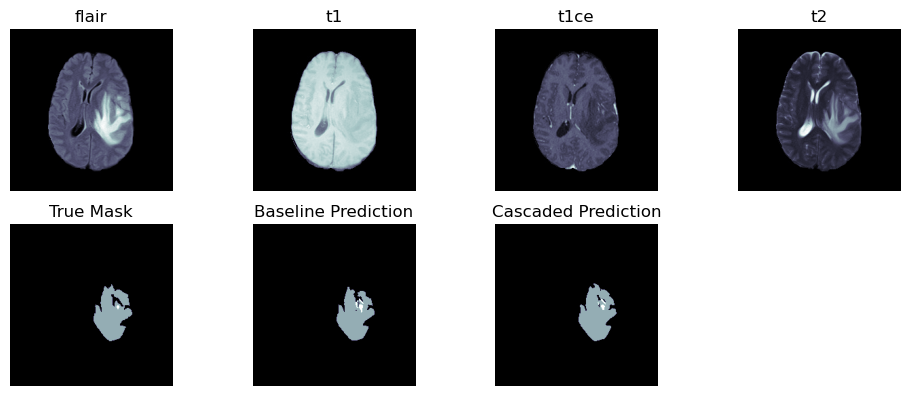

In [43]:
show_visual_result()